time [s]    T1 [K]      T2 [K]      V1 [m^3]    V2 [m^3]    V1+V2 [m^3]  X(CO)     
     0.004       900.0    900.0015         0.5         0.1         0.6      0.2853
     0.008       900.0    900.0030         0.5         0.1         0.6      0.2853
     0.012       900.0    900.0046         0.5         0.1         0.6      0.2853
     0.016       900.0    900.0062         0.5         0.1         0.6      0.2853
     0.020       900.0    900.0078         0.5         0.1         0.6      0.2853
     0.024       900.0    900.0094         0.5         0.1         0.6      0.2853
     0.028       900.0    900.0111         0.5         0.1         0.6      0.2853
     0.032       900.0    900.0128         0.5         0.1         0.6      0.2853
     0.036       900.0    900.0146         0.5         0.1         0.6      0.2853
     0.040       900.0    900.0163         0.5         0.1         0.6      0.2853
     0.044       900.0    900.0181         0.5         0.1         0.6      0.2853
   

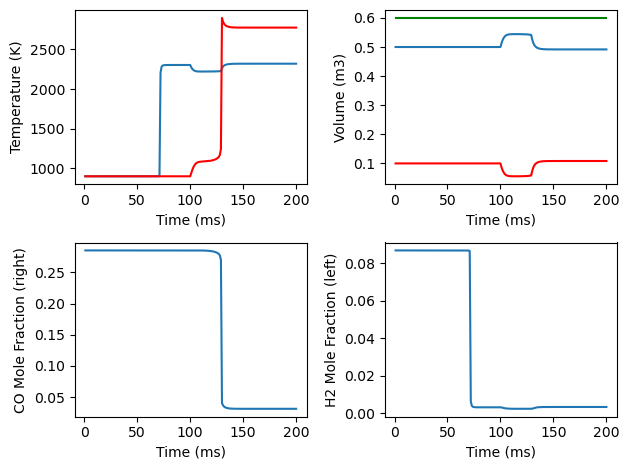

In [1]:
"""
Two reactors separated by a piston that moves with a speed proportional to the pressure
difference between the reactors.

Gas 1: a stoichiometric H2/O2/Ar mixture
Gas 2: a wet CO/O2 mixture

    -------------------------------------
    |          ||                       |
    |          ||                       |
    |  gas 1   ||        gas 2          |
    |          ||                       |
    |          ||                       |
    -------------------------------------

The two volumes are connected by an adiabatic free piston. The piston speed is
proportional to the pressure difference between the two chambers.

Note that each side uses a *different* reaction mechanism

Requires: cantera >= 2.5.0, matplotlib >= 2.0
Keywords: combustion, reactor network, plotting
"""

import sys
import matplotlib.pyplot as plt
import cantera as ct

fmt = '{:10.3f}  {:10.1f}  {:10.4f}  {:10.4g}  {:10.4g}  {:10.4g}  {:10.4g}'
print('{:10}  {:10}  {:10}  {:10}  {:10}  {:10}  {:10}'.format(
    'time [s]', 'T1 [K]', 'T2 [K]', 'V1 [m^3]', 'V2 [m^3]', 'V1+V2 [m^3]', 'X(CO)'))

gas1 = ct.Solution('h2o2.yaml')
gas1.TPX = 900.0, ct.one_atm, 'H2:2, O2:1, AR:20'

gas2 = ct.Solution('gri30.yaml')
gas2.TPX = 900.0, ct.one_atm, 'CO:2, H2O:0.01, O2:5'

r1 = ct.IdealGasReactor(gas1)
r1.volume = 0.5
r2 = ct.IdealGasReactor(gas2)
r2.volume = 0.1


# The wall is held fixed until t = 0.1 s, then released to allow the pressure to
# equilibrate.
def v(t):
    if t < 0.1:
        return 0.0
    else:
        return (r1.thermo.P - r2.thermo.P) * 1e-4


w = ct.Wall(r1, r2, velocity=v)

net = ct.ReactorNet([r1, r2])

states1 = ct.SolutionArray(r1.thermo, extra=['t', 'volume'])
states2 = ct.SolutionArray(r2.thermo, extra=['t', 'volume'])

for n in range(200):
    time = (n+1)*0.001
    net.advance(time)
    if n % 4 == 3:
        print(fmt.format(time, r1.T, r2.T, r1.volume, r2.volume,
                         r1.volume + r2.volume, r2.thermo['CO'].X[0]))

    states1.append(r1.thermo.state, t=1000*time, volume=r1.volume)
    states2.append(r2.thermo.state, t=1000*time, volume=r2.volume)

# plot the results if matplotlib is installed.

plt.subplot(2, 2, 1)
plt.plot(states1.t, states1.T, '-', states2.t, states2.T, 'r-')
plt.xlabel('Time (ms)')
plt.ylabel('Temperature (K)')
plt.subplot(2, 2, 2)
plt.plot(states1.t, states1.volume, '-', states2.t, states2.volume, 'r-',
         states1.t, states1.volume + states2.volume, 'g-')
plt.xlabel('Time (ms)')
plt.ylabel('Volume (m3)')
plt.subplot(2, 2, 3)
plt.plot(states2.t, states2('CO').X)
plt.xlabel('Time (ms)')
plt.ylabel('CO Mole Fraction (right)')
plt.subplot(2, 2, 4)
plt.plot(states1.t, states1('H2').X)
plt.xlabel('Time (ms)')
plt.ylabel('H2 Mole Fraction (left)')
plt.tight_layout()
plt.show()